## Camera Calibration

In [27]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib inline

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/*.jpg')

# Step through the list and search for chessboard corners
for index, filename in enumerate(images):
    img = cv2.imread(filename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        # cv2.drawChessboardCorners(img, (9,6), corners, ret)

## Test calibration result

(720, 1280, 3)
(1280, 720)


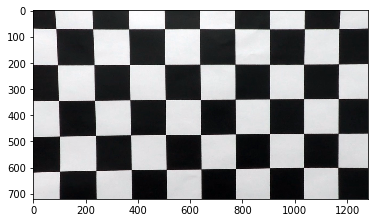

In [80]:
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
print(img.shape)
print(img_size)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(dst)

## Undistort Image

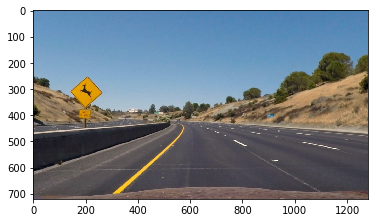

In [189]:
img = cv2.imread('test_images/test2.jpg')

def undistort(img):
    img_size = (img.shape[1], img.shape[0])

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    undist = cv2.undistort(img, mtx, dist, None, mtx)
    plt.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    # cv2.imwrite('test_images/straight_lines2_undistorted.jpg', dst)
    return undist

undist = undistort(img)
img = undist

## Prospective transform

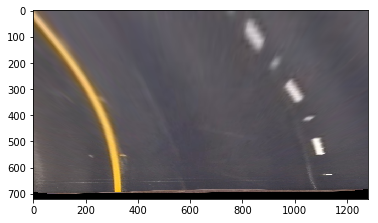

In [190]:
def warp(img):
    src = np.float32(
        [[260, 691],
         [602, 446],
         [683, 446],
         [1049, 682]])

    dst = np.float32(
        [[260, 691],
         [260, 0],
         [1049, 0],
         [1049, 682]])

    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    return warped

warped = warp(img)
img = warped

## Calculate binary image

(720, 1280, 3)
(720, 1280)
(720, 1280)


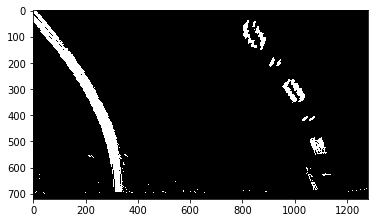

In [191]:
def to_binary(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    print(hls.shape)

    s_channel = hls[:,:,2]
    print(s_channel.shape)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    print(gray.shape)

    # Filter by saturation

    s_threshold_min = 170
    s_threshold_max = 255
    s_binary = np.zeros_like(s_channel)

    s_binary[(s_channel >= s_threshold_min) & (s_channel <= s_threshold_max)] = 1
    # plt.imshow(s_binary, cmap='gray')

    # Filter by gradient at X axis

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    sobel_threshold_min = 20
    sobel_threshold_max = 100

    sx_binary = np.zeros_like(gray)
    sx_binary[(scaled_sobelx >= sobel_threshold_min) & (scaled_sobelx <= sobel_threshold_max)] = 1
    # plt.imshow(sx_binary, cmap='gray')

    # Combine both filter results
    combined_binary = np.zeros_like(gray)
    combined_binary[(s_binary == 1) | (sx_binary == 1)] = 1
    plt.imshow(combined_binary, cmap='gray')
    return combined_binary

combined_binary = to_binary(img)
img = combined_binary


## Find lane

In [186]:
histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)

print(img.shape[0])

AttributeError: 'NoneType' object has no attribute 'shape'

In [195]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def calc_lane(img):
    print(img.shape)

    # Take a histogram of the bottom half the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # print(histogram.shape)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255


    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # print(midpoint)
    # print(leftx_base)
    # print(rightx_base)

    # Choose the number of sliding windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()

    # print(nonzero)

    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_idxs = []
    right_lane_idxs = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window + 1) * window_height
        win_y_high = img.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_idxs = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_idxs = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_idxs.append(good_left_idxs)
        right_lane_idxs.append(good_right_idxs)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_idxs) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_idxs]))
        if len(good_right_idxs) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_idxs]))

    # Concatenate the arrays of indices
    left_lane_idxs = np.concatenate(left_lane_idxs)
    right_lane_idxs = np.concatenate(right_lane_idxs)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_idxs]
    lefty = nonzeroy[left_lane_idxs] 
    rightx = nonzerox[right_lane_idxs]
    righty = nonzeroy[right_lane_idxs] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_idxs], nonzerox[left_lane_idxs]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_idxs], nonzerox[right_lane_idxs]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    return left_fitx, right_fitx



## Draw on original image

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


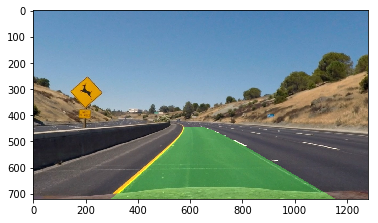

In [193]:
# Create an image to draw the lines on
color_warp = np.zeros_like(warped).astype(np.uint8)

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0]))

# warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

print(color_warp.shape)
print(newwarp.shape)
print(undist.shape)

# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

In [181]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/300 # meters per pixel in y dimension
xm_per_pix = 3.7/900 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit_cr[0])
right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit_cr[0])

# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

1840.65823765 m 1563.36271368 m
